In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr

import statistics 
from statistics import mean 
from statistics import stdev 

### Function Definitions 

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF

# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
  #  DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
  #           'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
  #          'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
  #          'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
    
    DF = DF[['Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

def rom(list_of_arrays):

    
    reps_max_values = np.array([np.max(array) for array in list_of_arrays])
    reps_min_values = np.array([np.min(array) for array in list_of_arrays])
    
    
    ROM = reps_max_values - reps_min_values
    
    return ROM

In [4]:
# Signal Processing

# sampling frequency set to 100 HZ
fsample = 100

def sig_shift(signal, amount):
    length = len(signal)    
    shifted = np.zeros(length+amount - 1)
    shifted[:amount-1] = 0
    shifted[amount-1:] = signal[:]
    return shifted

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_normalised = signal - signal_mean
    return signal_normalised

# Butterworth filter 8-order, 15hz cutoff
fc = 15
w = fc / (fsample/2)
b , a = signal.butter(8, w, btype ='lowpass')

### Reading, Cleaning, and Preprocessing DATA

9.606527121666385 0.3326165705222511


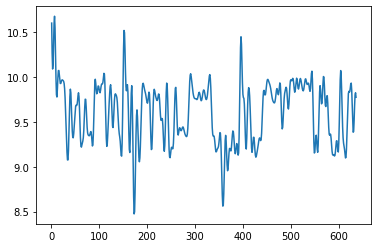

In [5]:
# Get the normalization constant from the rest file 
### video
path = r'/home/deniz/Code/ValidationStudy/01/RSSDK/landmarks_finetuned/AF11_02_RES_REST1_1259_landmarksFiltered3D.csv'

rest = pd.read_csv(path)
# clean the spreadsheet to the desired df format
rest =  rest.drop([0]) 
rest = cleaning_video_df(rest)
rest['Task'] = 'REST'
rest = lipDist(rest)

rest['Vert_Lip_Motion']= signal.filtfilt(b, a, rest['Vert_Lip_Motion'])
vertical_lip = rest['Vert_Lip_Motion'].values 
# plot
plt.plot(rest['Vert_Lip_Motion'])



# cut the beggining and end 
end = len (vertical_lip) 
v_lip = vertical_lip[0:end]
rest_v = mean(v_lip)
rest_st_v = stdev(v_lip)

print(rest_v, rest_st_v)
# take mean and standard dev 


17.73582249237001 0.060622371806979915


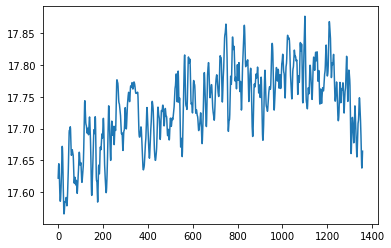

In [6]:
# Get the normalization constant from the rest file 
### wave
path = r'/home/deniz/Code/ValidationStudy/01/WAVE/AF11_01_SBK_20200211_001_RST_REST1.tsv'

rest = pd.read_csv(path, delimiter='\t', skiprows=1,header=None)
rest = cleaning_wave_df(rest)
# clean the spreadsheet to the desired df format

rest['Task'] = 'REST'
rest = lipDist(rest)

rest['Vert_Lip_Motion']= signal.filtfilt(b, a, rest['Vert_Lip_Motion'])
vertical_lip = rest['Vert_Lip_Motion'].values 
# plot
plt.plot(rest['Vert_Lip_Motion'])



# cut the beggining and end 
end = len (vertical_lip) 
w_lip = vertical_lip[0:end]
rest_w = mean(w_lip)
rest_st_w = stdev(w_lip)

print(rest_w, rest_st_w)
# take mean and standard dev 

In [7]:
Tasks = ['REST', 'OPEN', 'SPREAD', 'OOEE', 'PA', 'BBP', 'PATAKA', 'KA', 'EYESMIN', 'COUNT', 'BROW', 'EYESMAX']
Conditions = ['FAST', 'SLOW', 'DIS', 'HOLD', 'NORMAL', 'LOUD']

video_df_list = list()
video_100_list = list()

In [8]:
#path = r'/home/deniz/Code/ValidationStudy/01/RSSDK/landmarks_finetuned/AF11_02_BBP_LOUD_1308_landmarksFiltered3D.csv'

In [9]:
path_v = r'/home/deniz/Code/ValidationStudy/madhura_SBK_20200806/landmarks_finetuned'
#path_v = r'/home/deniz/Code/ValidationStudy/01/RSSDK/landmarks_finetuned'
ext_v=('_landmarksFiltered3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

print(len(Files_v))
Files_v

12


['madhura_02_BBP_NORMAL_1212_landmarksFiltered3D.csv',
 'madhura_02_PSG_BAMBOO_1225_landmarksFiltered3D.csv',
 'madhura_02_RST_REST1_1211_landmarksFiltered3D.csv',
 'madhura_02_NSM_BIGSMILE_1217_landmarksFiltered3D.csv',
 'madhura_02_RST_REST1_1210_landmarksFiltered3D.csv',
 'madhura_02_NSM_SPREAD_1220_landmarksFiltered3D.csv',
 'madhura_02_DDK_PA_1215_landmarksFiltered3D.csv',
 'madhura_02_NSM_OPEN_1219_landmarksFiltered3D.csv',
 'madhura_02_NSM_OOEE_1218_landmarksFiltered3D.csv',
 'madhura_02_DDK_PATAKA_1216_landmarksFiltered3D.csv',
 'madhura_02_PSG_BAMBOO_1221_landmarksFiltered3D.csv',
 'madhura_02_BBP_SLOW_1213_landmarksFiltered3D.csv']

BBP
2617
1570
1573
1         NaN
2    0.016649
3    0.016635
4    0.016762
5    0.016589
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




REST
1179
707
710
1         NaN
2    0.016850
3    0.016615
4    0.016614
5    0.016657
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




REST
936
561
564
1         NaN
2    0.016927
3    0.016451
4    0.016713
5    0.016566
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




SPREAD
1461
876
877
1         NaN
2    0.016789
3    0.016584
4    0.016671
5    0.016624
Name: Time, dtype: float64
1
10    0.050036
Name: Time, dtype: float64

0.050035644531250006



PA
1187
712
715
1         NaN
2    0.016775
3    0.016530
4    0.016630
5    0.016707
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




OPEN
1376
825
828


/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

1         NaN
2    0.016691
3    0.016592
4    0.016652
5    0.016673
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




OOEE
1504
902
905


/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

1         NaN
2    0.017001
3    0.016454
4    0.016637
5    0.016643
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




PA
1326
795
798
1         NaN
2    0.016652
3    0.016607
4    0.016724
5    0.016616
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)






/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

PATAKA
1326
795
798
1         NaN
2    0.016652
3    0.016607
4    0.016724
5    0.016616
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




KA
1326
795
798


/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

1         NaN
2    0.016652
3    0.016607
4    0.016724
5    0.016616
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)




BBP
4634
2780
2784
1         NaN
2    0.016645
3    0.016623
4    0.016630
5    0.016618
Name: Time, dtype: float64
0
Series([], Name: Time, dtype: float64)






/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/deniz/.pyenv/versions/realSenseAdd/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

<Figure size 432x288 with 0 Axes>

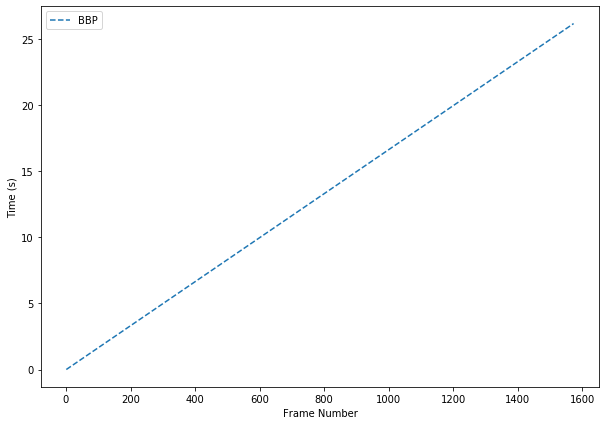

<Figure size 432x288 with 0 Axes>

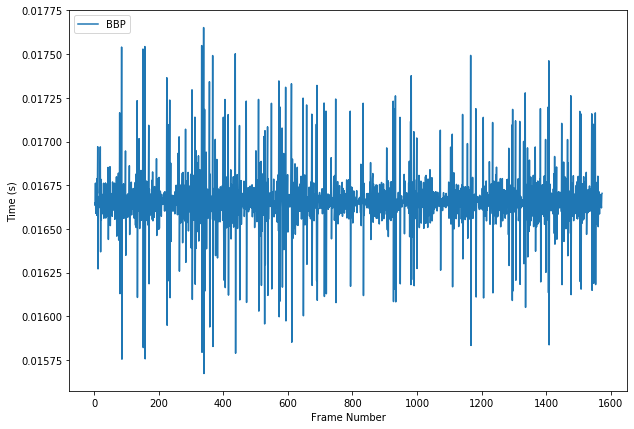

<Figure size 432x288 with 0 Axes>

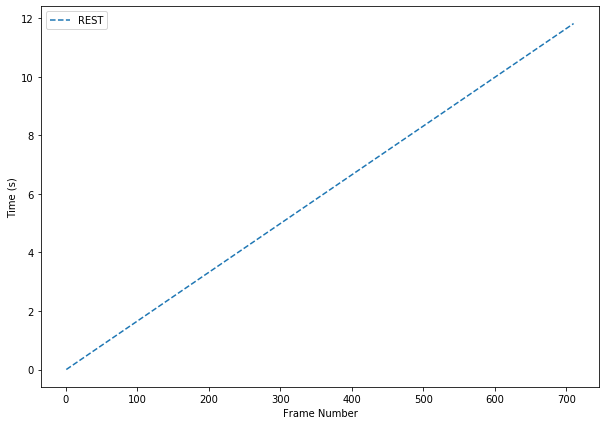

<Figure size 432x288 with 0 Axes>

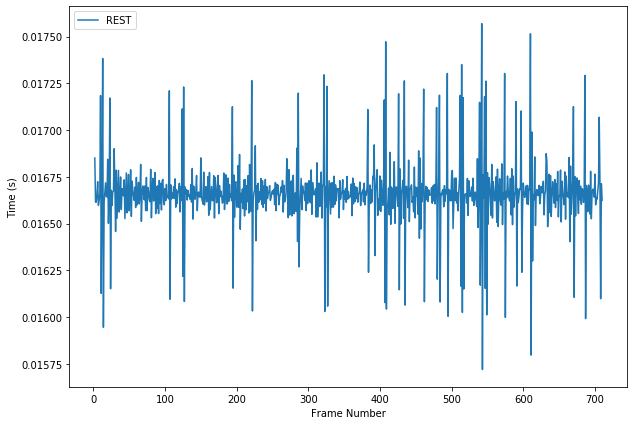

<Figure size 432x288 with 0 Axes>

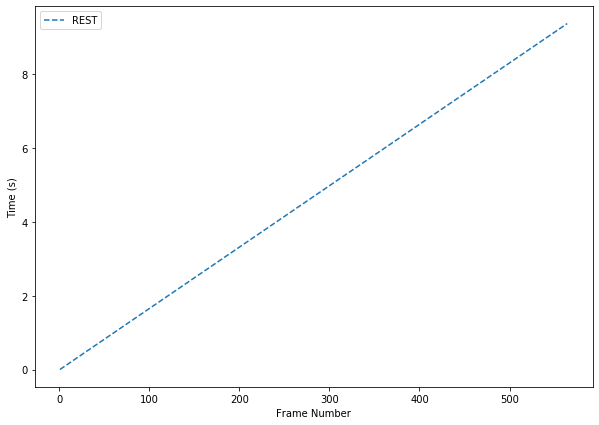

<Figure size 432x288 with 0 Axes>

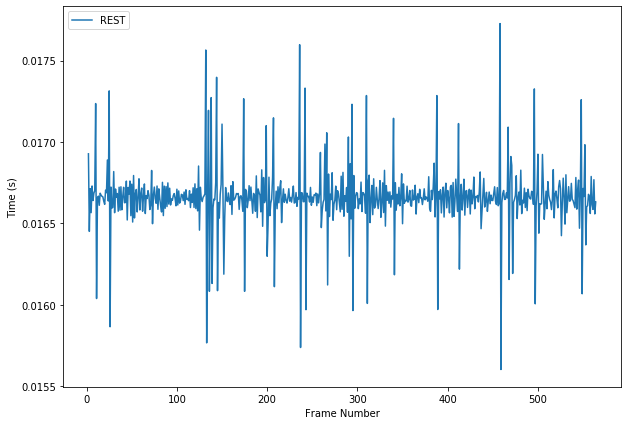

<Figure size 432x288 with 0 Axes>

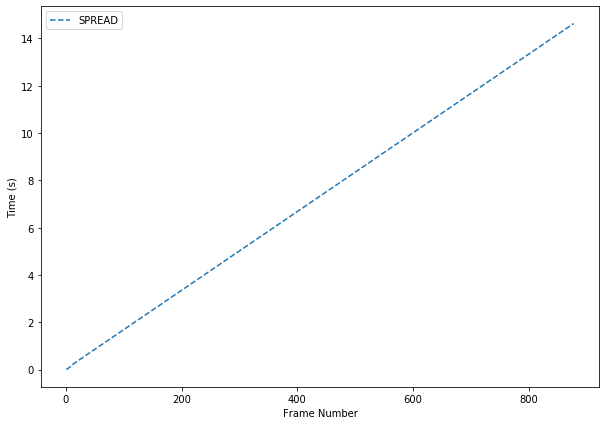

<Figure size 432x288 with 0 Axes>

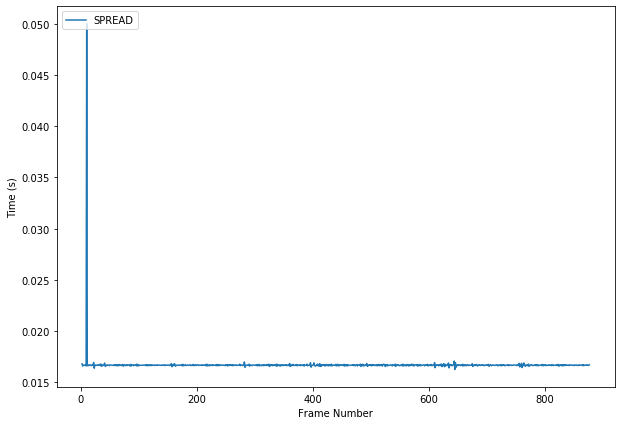

<Figure size 432x288 with 0 Axes>

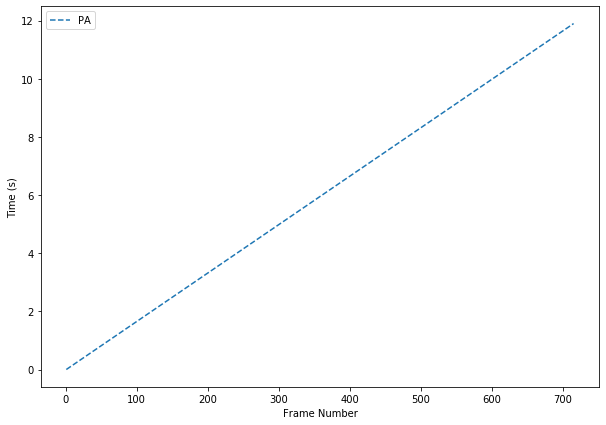

<Figure size 432x288 with 0 Axes>

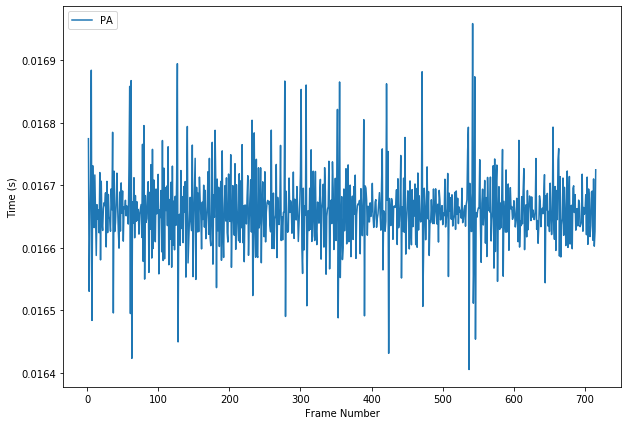

<Figure size 432x288 with 0 Axes>

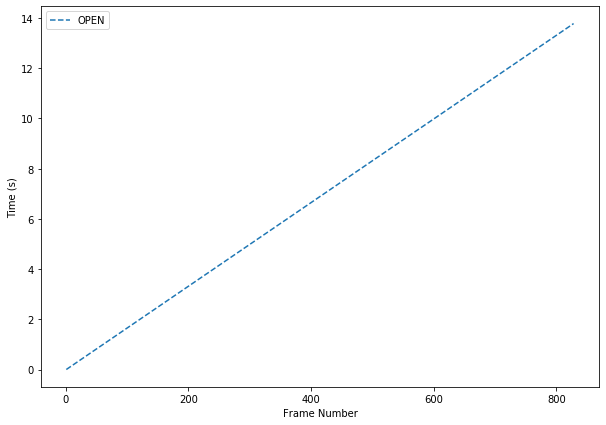

<Figure size 432x288 with 0 Axes>

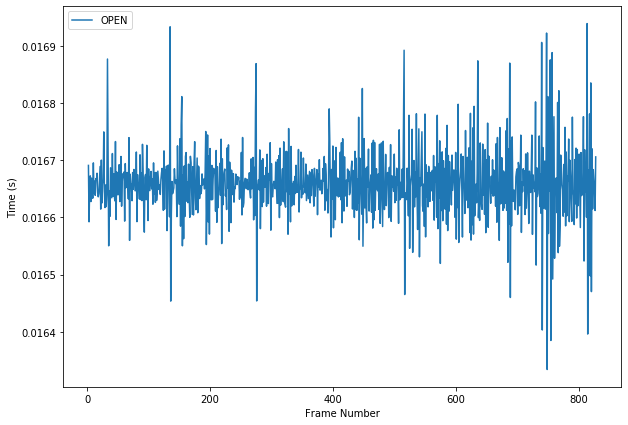

<Figure size 432x288 with 0 Axes>

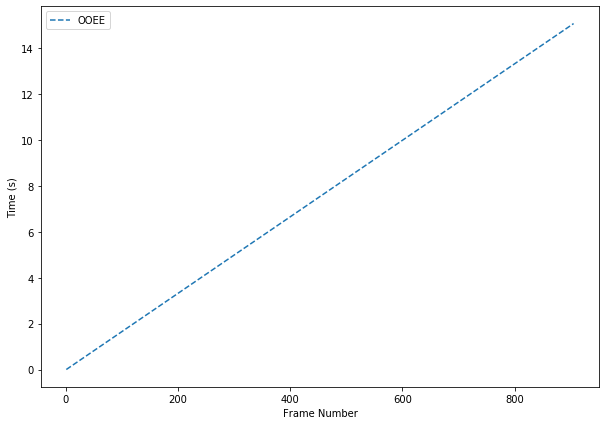

<Figure size 432x288 with 0 Axes>

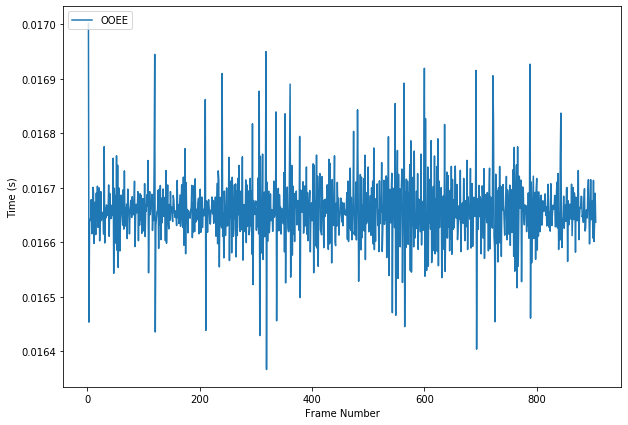

<Figure size 432x288 with 0 Axes>

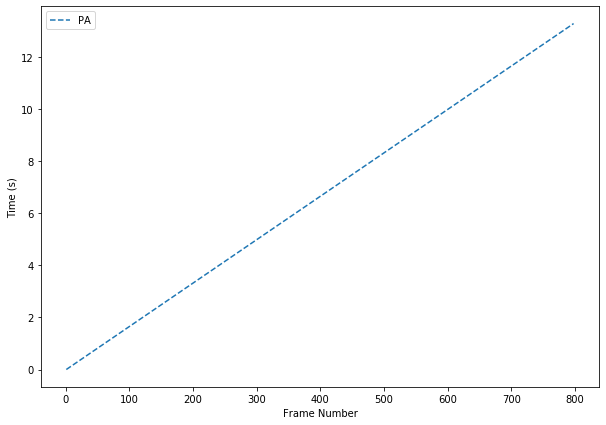

<Figure size 432x288 with 0 Axes>

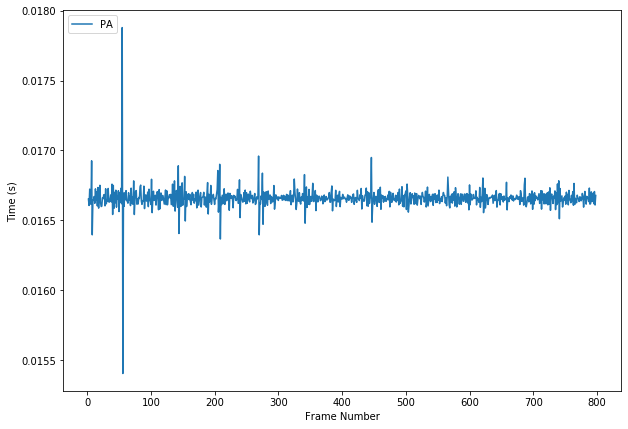

<Figure size 432x288 with 0 Axes>

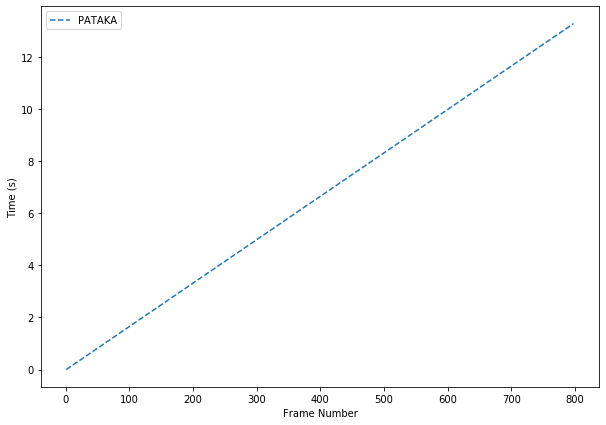

<Figure size 432x288 with 0 Axes>

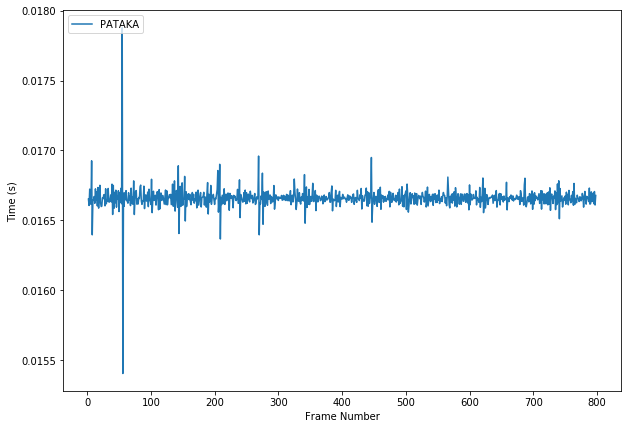

<Figure size 432x288 with 0 Axes>

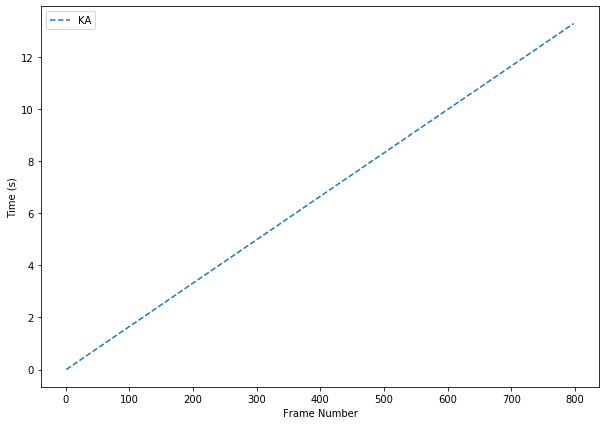

<Figure size 432x288 with 0 Axes>

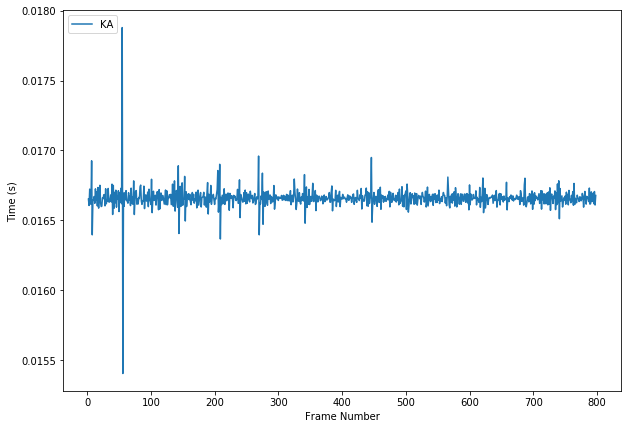

<Figure size 432x288 with 0 Axes>

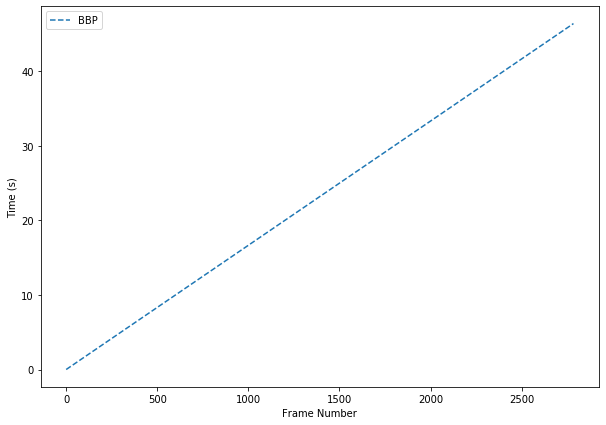

<Figure size 432x288 with 0 Axes>

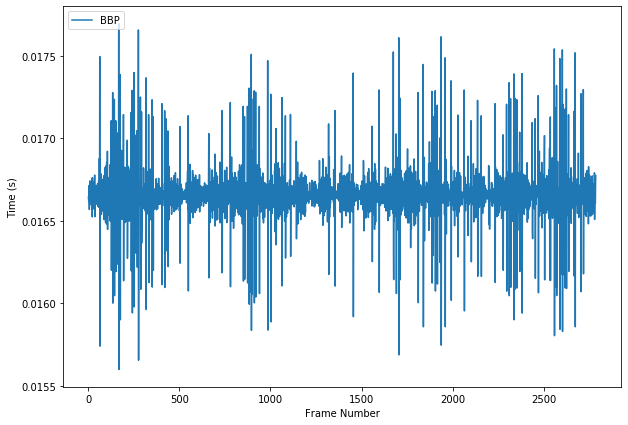

In [10]:

for file in Files_v:
    
    for task in Tasks:
        
        if task in file:
            Task = task

            # read the data from spreadsheet 
            df = pd.read_csv(path_v+ "/" + file)
            # clean the spreadsheet to the desired df format
            df =  df.drop([0]) 
            df = cleaning_video_df(df)
            # add the tast 
            df['Task'] = Task

            #df = df.interpolate(method ='cubic', limit_direction ='forward') 

            # find the vertical distance 
            df = lipDist(df)
            # use butterworth filter to smoothen the signal 
            
            
            # THE SIGNALS WITH AND WITHOUT FILTER 
            #plt.figure()
            #ax, figure = plt.subplots(figsize=(10,7))
            #plt.plot(df['Vert_Lip_Motion'])
            #plt.xlabel('Frames')
            #plt.ylabel('Vertical Range of Motion')
            #plt.title('Raw Signal')


            df['Vert_Lip_Motion_filtered']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
            #plt.figure()
            #ax, figure = plt.subplots(figsize=(10,7))
            #plt.plot(df['Vert_Lip_Motion'], label = Task)
            #plt.legend(loc="upper left")
            #plt.xlabel('Frames')
            #plt.ylabel('Vertical Range of Motion')
            #plt.title('Filtered Signal')


            #df['Vert_Lip_Motion'] = df['Vert_Lip_Motion'] - rest_v

            #plt.figure()
            #ax, figure = plt.subplots(figsize=(10,7))
            #plt.plot(df['Vert_Lip_Motion'])
            #plt.plot(df['Vert_Lip_Motion'], 'o')
            #plt.xlabel('Frames')
            #plt.ylabel('Vertical Range of Motion')
            #plt.title('Filtered Normalized Signal')

            tmax = len(df.Time) - 1
            tmax_value = df.Time[tmax]
            tmin_value = df.Time[1]
            nsample = fsample*(tmax_value - tmin_value)
            nsample = int(nsample)
            tmax_ideal = tmin_value + (nsample/fsample)
            perfect_time = np.linspace(tmin_value, tmax_ideal, num= nsample, endpoint=True)

            nsample_60 = 60*(tmax_value - tmin_value)
            nsample_60 = int(nsample_60)
            tmax_ideal_60 = tmin_value + (nsample/60)
            perfect_time_60 = np.linspace(tmin_value, tmax_ideal, num= nsample_60, endpoint=True)
            print(Task)
            print(len(perfect_time))
            print(len(perfect_time_60))
            print(len(df["Time"]))

            video_df = pd.DataFrame()
            video_df['Perf_Time'] = perfect_time
            f_motion = interp1d(df['Time'], df['Vert_Lip_Motion'], kind = 'linear')
            video_df['Vert_Lip_100'] = f_motion(perfect_time)

            f_motion = interp1d(df['Time'], df['Vert_Lip_Motion'], kind = 'cubic')
            video_df['Vert_Lip_100_c'] = f_motion(perfect_time)


            plt.figure()
            ax, figure = plt.subplots(figsize=(10,7))
            plt.plot(df['Time'], '--', label= Task)
            plt.legend(loc="upper left")
            plt.xlabel('Frame Number')
            plt.ylabel('Time (s)')


            delta = df['Time'].diff()

            plt.figure()
            ax, figure = plt.subplots(figsize=(10,7))
            plt.plot(delta, label= Task)
            plt.legend(loc="upper left")
            plt.xlabel('Frame Number')
            plt.ylabel('Time (s)')
            large_jumps = np.where(delta>0.04)
            #print(large_jumps)
            large_jumps = [a+1 for a in large_jumps]
            large_jumps_values = delta[large_jumps[0]]
            print(delta[:5])
            print(len(large_jumps_values))
            print(large_jumps_values)
            print()
            if len(large_jumps_values) != 0:
                print(max(large_jumps_values))
            print()
            print()
            print()
            video_df_list.append(df)
            video_100_list.append(video_df)

In [11]:
# sample the time to perfect 100 Hz
# Video Data 
tmax = len(df.Time) - 1
tmax_value = df.Time[tmax]
tmin_value = df.Time[1]
nsample = fsample*(tmax_value - tmin_value)
nsample = int(nsample)
tmax_ideal = tmin_value + (nsample/fsample)
perfect_time = np.linspace(tmin_value, tmax_ideal, num= nsample, endpoint=True)

nsample_60 = 60*(tmax_value - tmin_value)
nsample_60 = int(nsample_60)
tmax_ideal_60 = tmin_value + (nsample/60)
perfect_time_60 = np.linspace(tmin_value, tmax_ideal, num= nsample_60, endpoint=True)

print(len(perfect_time))
print(len(perfect_time_60))
print(len(df["Time"]))

video_df = pd.DataFrame()
video_df['Perf_Time'] = perfect_time
f_motion = interp1d(df['Time'], df['Vert_Lip_Motion'], kind = 'linear')
video_df['Vert_Lip_100'] = f_motion(perfect_time)

f_motion = interp1d(df['Time'], df['Vert_Lip_Motion'], kind = 'cubic')
video_df['Vert_Lip_100_c'] = f_motion(perfect_time)


# calculate the velocity 
#video_df["Speed_100"] = np.gradient(video_df['Vert_Lip_100'], video_df["Perf_Time"])

4634
2780
2784


<Figure size 432x288 with 0 Axes>

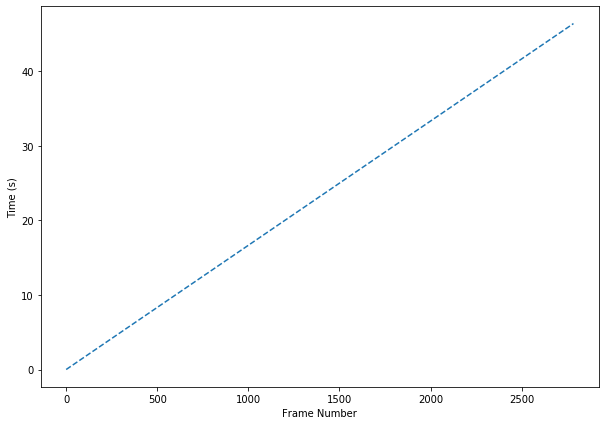

<Figure size 432x288 with 0 Axes>

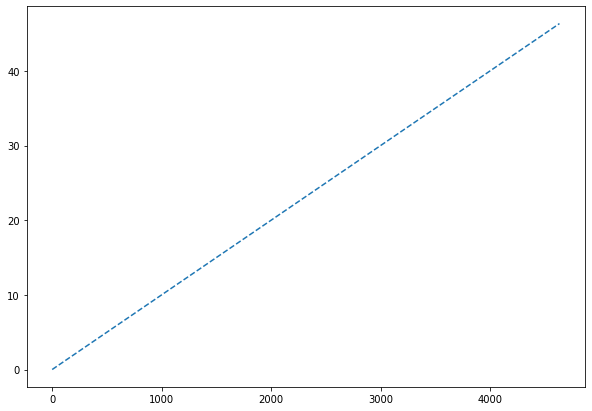

In [12]:
plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df['Time'], '--')
#plt.plot(df['Time'], '--', label = "Video Data Time Stamp")
#plt.plot(perfect_time_60, 'r', label = "Perfect 60Hz Time Stamp")

#plt.legend(loc="upper right")
plt.xlabel('Frame Number')
plt.ylabel('Time (s)')

plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Perf_Time'], '--')

In [13]:
df['Time'].diff()

1            NaN
2       0.016645
3       0.016623
4       0.016630
5       0.016618
          ...   
2780    0.016674
2781    0.016658
2782    0.016607
2783    0.016714
2784    0.016774
Name: Time, Length: 2784, dtype: float64

(array([], dtype=int64),)
0
Series([], Name: Time, dtype: float64)


<Figure size 432x288 with 0 Axes>

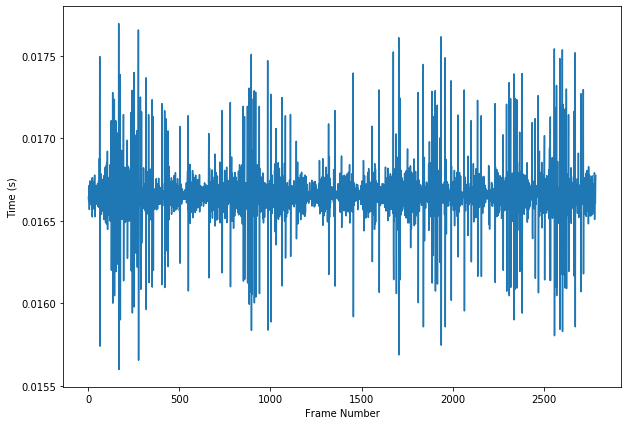

In [14]:
delta = df['Time'].diff()

plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(delta)
plt.xlabel('Frame Number')
plt.ylabel('Time (s)')
large_jumps = np.where(delta>0.02)
print(large_jumps)
large_jumps = [a+1 for a in large_jumps]
large_jumps_values = delta[large_jumps[0]]
print(len(large_jumps_values))
print(large_jumps_values)
#delta[1164]

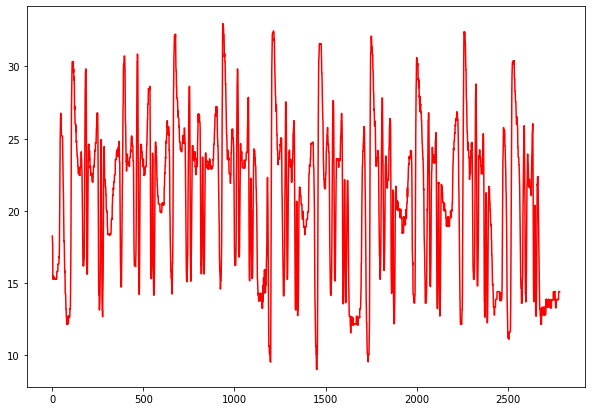

<Figure size 432x288 with 0 Axes>

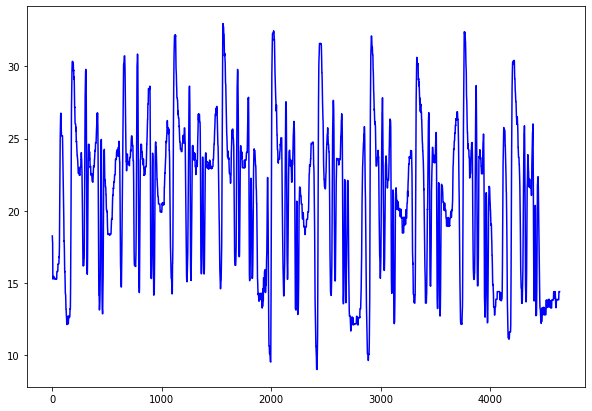

<Figure size 432x288 with 0 Axes>

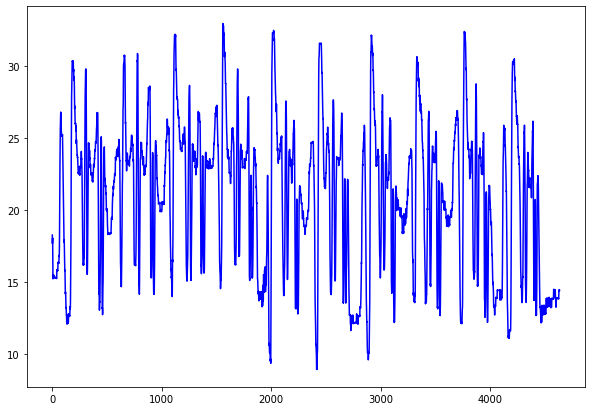

In [15]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df['Vert_Lip_Motion'], 'r')



plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Vert_Lip_100'], 'b')


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Vert_Lip_100_c'], 'b')



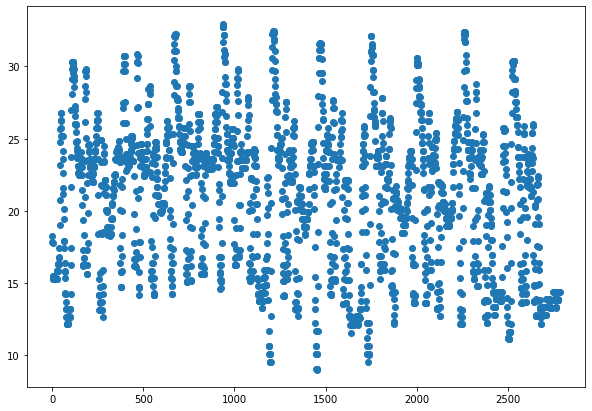

<Figure size 432x288 with 0 Axes>

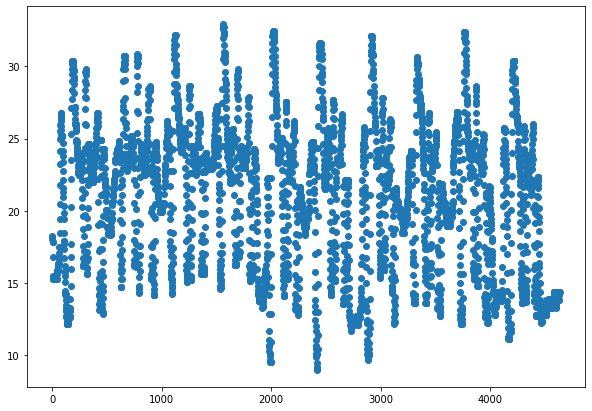

In [16]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df['Vert_Lip_Motion'], 'o')

plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Vert_Lip_100'], 'o')

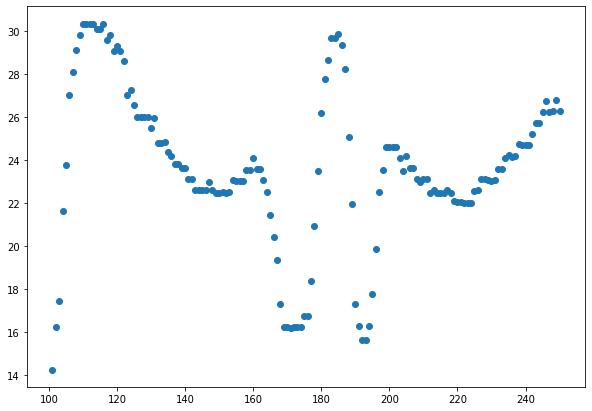

<Figure size 432x288 with 0 Axes>

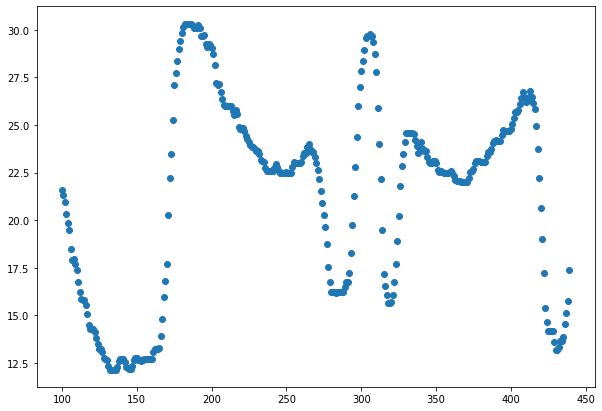

In [17]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df['Vert_Lip_Motion'][100:250], 'o')

plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Vert_Lip_100'][100:440], 'o')

Text(0, 0.5, 'Vertical Range of Motion (mm)')

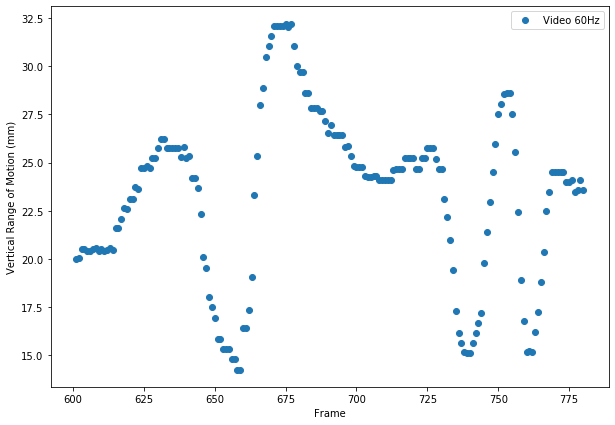

<Figure size 432x288 with 0 Axes>

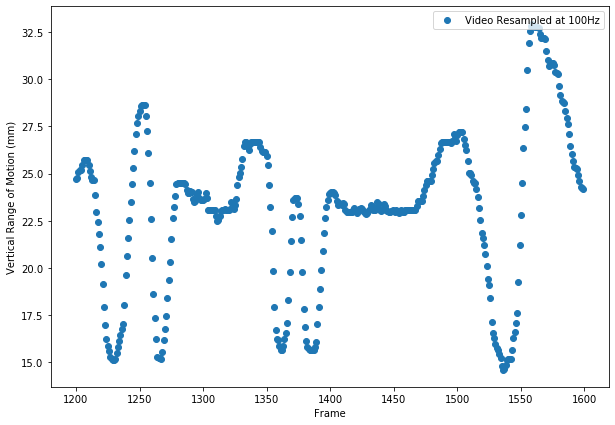

In [18]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df['Vert_Lip_Motion'][600:780], 'o', label="Video 60Hz")

plt.legend(loc="upper right")
plt.xlabel('Frame')
plt.ylabel('Vertical Range of Motion (mm)')


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Vert_Lip_100'][1200:1600], 'o', label="Video Resampled at 100Hz")
plt.legend(loc="upper right")
plt.xlabel('Frame')
plt.ylabel('Vertical Range of Motion (mm)')

16
[ 134  459  704  926 1230 1536 1758 1995 2418 2659 2886 3123 3519 3740
 4170 4465]


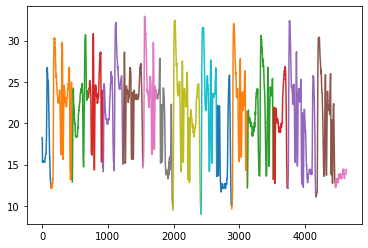

In [19]:
peaks, _ = signal.find_peaks(-video_df['Vert_Lip_100'], height= -32, distance= 220)
print(len(peaks))
print(peaks)

reps = np.array_split(video_df['Vert_Lip_100'], peaks)

plt.figure()
for i in reps:
    plt.plot(i)


In [20]:
path_w = r'/home/deniz/Code/ValidationStudy/01/WAVE/AF11_01_SBK_20200211_008_BBP_LOUD.tsv'

df_w = pd.read_csv(path_w, delimiter='\t', skiprows=1,header=None)
df_w = cleaning_wave_df(df_w)
df_w['Task'] = Task
df_w = df_w.interpolate(method ='cubic', limit_direction ='forward') 
df_w = lipDist(df_w)
df_w['Vert_Lip_Motion']= signal.filtfilt(b, a, df_w['Vert_Lip_Motion'])
df_w['Vert_Lip_Motion'] = df_w['Vert_Lip_Motion'] - rest_w
df_w.head()

,Time,FrameID,SensorID,Sensor_1Status,X_Nose,Y_Nose,Z_Nose,SensorID,Sensor_2Status,X_LLeft,...,Y_JR,Z_JR,SensorID,Senson_7Status,X_JL,Y_JL,Z_JL,Task,Horiz_Lip_Motion,Vert_Lip_Motion
0,0.0333,0,0,55,60.234592,-13.783323,-182.48920,2,55,-25.033363,...,11.519699,-150.58009,7,55,-52.831776,-0.576992,-209.90816,BBP,58.777102,-0.125209
1,0.0433,1,0,55,60.260159,-13.751879,-182.45642,2,55,-25.006454,...,11.497246,-150.57709,7,55,-52.788460,-0.534978,-209.91885,BBP,58.783619,-0.155646
2,0.0533,2,0,55,60.324436,-13.675396,-182.47890,2,55,-24.980934,...,11.518082,-150.56520,7,55,-52.808128,-0.494998,-209.89305,BBP,58.803553,-0.175683
3,0.0633,3,0,55,60.382896,-13.617325,-182.53253,2,55,-24.940662,...,11.562665,-150.55597,7,55,-52.781818,-0.481719,-209.88435,BBP,58.769822,-0.180477
4,0.0733,4,0,55,60.488758,-13.568037,-182.58598,2,55,-24.905054,...,11.576636,-150.55492,7,55,-52.727024,-0.408235,-209.88229,BBP,58.763591,-0.172997


In [21]:
# sample the time to perfect 100 Hz
# WAVE Data 
tmax = len(df_w.Time) - 1
tmax_value = df_w.Time[tmax]
tmin_value = df_w.Time[1]
nsample = fsample*(tmax_value - tmin_value)
nsample = int(nsample)
tmax_ideal = tmin_value + (nsample/fsample)
perfect_time = np.linspace(tmin_value, tmax_ideal, num= nsample, endpoint=True)

print(len(perfect_time))
print(len(df_w["Time"]))

wave_df = pd.DataFrame()
wave_df['Perf_Time'] = perfect_time
f_motion = interp1d(df_w['Time'], df_w['Vert_Lip_Motion'], kind = 'linear')
wave_df['Vert_Lip_100'] = f_motion(perfect_time)
# calculate the velocity 
wave_df["Speed_100"] = np.gradient(wave_df['Vert_Lip_100'], wave_df["Perf_Time"])


3107
3112


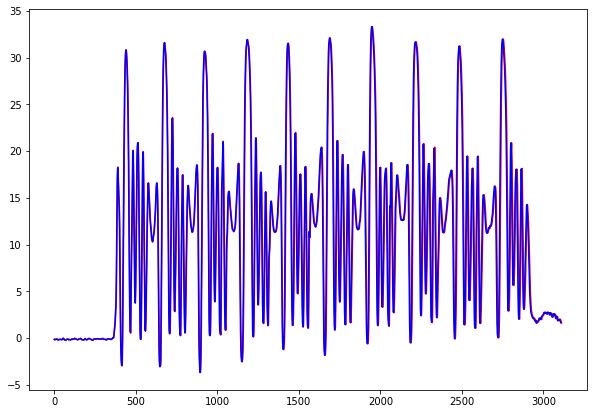

In [22]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df_w['Vert_Lip_Motion'],'r')
plt.plot(wave_df['Vert_Lip_100'], 'b')

<Figure size 432x288 with 0 Axes>

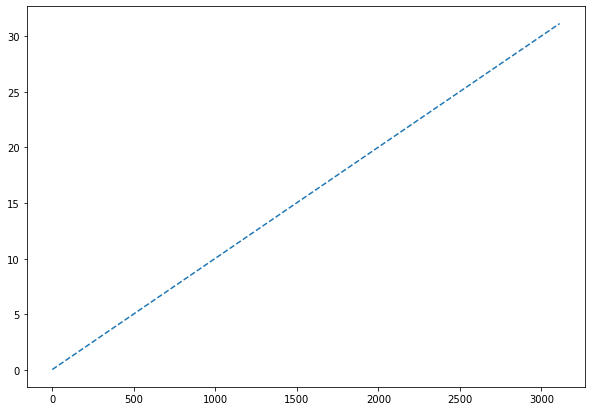

<Figure size 432x288 with 0 Axes>

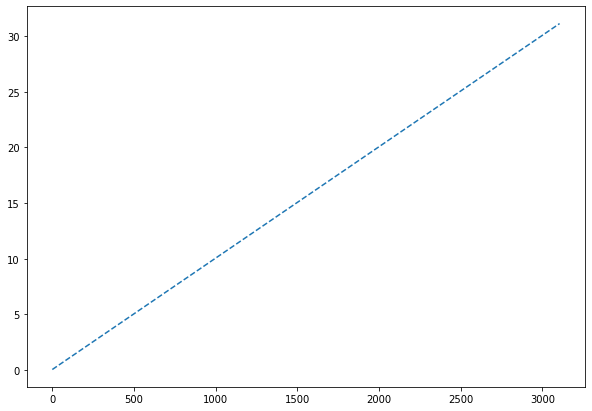

In [23]:
plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(df_w['Time'], '--')

plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(wave_df['Perf_Time'], '--')

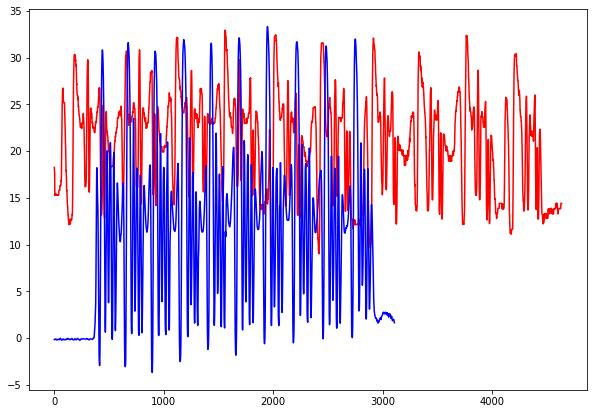

In [24]:
ax, figure = plt.subplots(figsize=(10,7))
plt.plot(video_df['Vert_Lip_100'],'r')
plt.plot(wave_df['Vert_Lip_100'], 'b')

In [25]:
video_df.head()

,Perf_Time,Vert_Lip_100,Vert_Lip_100_c
0,0.000000,18.261627,18.261627
1,0.010002,18.025529,17.671226
2,0.020004,17.856692,18.011130
3,0.030006,17.820845,18.060522
4,0.040009,16.785170,16.785792


In [26]:

result = pd.DataFrame() 

video_n = sig_norm(video_df['Vert_Lip_100'].values)

wave_n = sig_norm(wave_df['Vert_Lip_100'].values)
#     video_n = video_n[200:-50]
#     wave_n = wave_n[200:-50]


time_w = wave_df['Perf_Time'].values
time_v = video_df['Perf_Time'].values
#     time = time[200:-50]

if len(video_n)<=len(wave_n):
    upper_bound = len(video_n) 
else: 
    upper_bound = len(wave_n) 


s = phase_align(wave_n, video_n, [5,upper_bound])
print('The phase shift is:{}'.format(s))

sp = math.floor(s)


video_shifted = sig_shift(video_df['Vert_Lip_100'],sp)
video_speed_shifted = sig_shift(video_df['Speed_100'],sp)
video_n_s = sig_shift(video_n, sp)
wave = wave_df['Vert_Lip_100'].values
wave_speed = wave_df['Speed_100'].values

upper_bound_shifted = upper_bound + sp -1

if len(wave)< upper_bound_shifted:
    upper_bound_shifted = len(wave)


print('Video:{}'.format(len(video_df['Vert_Lip_100'])))
print('Video shifted:{}'.format(len(video_shifted)))
print('WAVE:{}'.format(len(wave)))
# print('UPPER_BOUND_SHIFTED:{}'.format(upper_bound_shifted))
# print('UPPER_BOUND:{}'.format(upper_bound))


range_l = sp+50
range_u = upper_bound_shifted-50

plt.figure()
plt.plot(video_shifted, 'r')
plt.plot(wave, 'b')
plt.plot(video_df['Vert_Lip_100'].values)


print(range_l,range_u,upper_bound_shifted)

print(len(time_w[range_l:range_u]))
t_u = range_u - range_l 
print(len(time_v[0:t_u]))


result['Time_WAVE'] = time_w[range_l:range_u]
result['Time_VIDEO'] = time_v[0:t_u]
#result['Time'] = time[range_l:range_u]
result['VerDisp_WAVE'] = wave[range_l:range_u]
result['VerDisp_VIDEO'] = video_shifted[range_l:range_u]

#  result['HorDisp_WAVE']
#  result['HorDisp_VIDEO']

result['Speed_WAVE'] = wave_speed[range_l:range_u]
result['Speed_VIDEO'] = video_speed_shifted[range_l:range_u]

name = 'BBP_Loud_ALS1'
cvs = name + '.csv'
result.to_csv(cvs)

plt.figure()

# plt.plot(time[sp:upper_bound_shifted], wave_shifted[sp:upper_bound_shifted],'b', label='Ground truth (WAVE)')
# plt.plot(time[sp:upper_bound_shifted],video_shifted[sp:upper_bound_shifted],'r', label='Video + FAN tracking')
plt.plot(time_w[range_l:range_u], wave[range_l:range_u],'b', label='Ground truth (WAVE)')
plt.plot(time_w[range_l:range_u],video_shifted[range_l:range_u],'r', label='Video + FAN tracking')
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Vertical Range of Motion (mm)')

plt.savefig('{}'.format(name))


plt.figure()
# plt.plot(wave_n[100:upper_bound],'b')
# plt.plot(video_n_s[100:upper_bound],'r')
plt.plot(time_w[range_l:range_u],wave_n[range_l:range_u],'b', label='Normalized Ground truth (WAVE)')
plt.plot(time_w[range_l:range_u],video_n_s[range_l:range_u],'r', label='Normalized Video + FAN tracking')
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Vertical Range of Motion (mm)')
plt.savefig('{}'.format(name+'Normalized'))

plt.figure()
plt.scatter(wave[range_l:range_u], video_shifted[range_l:range_u]) 


r, p = stats.pearsonr(video_n_s[range_l:range_u], wave_n[range_l:range_u])
rms = np.sqrt(np.mean((wave_n[range_l:range_u]-video_n_s[range_l:range_u])**2))

print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
print()



The phase shift is:194.32


KeyError: 'Speed_100'

In [ ]:
reps = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6','R7','R8', 'R9', 'R10']

def apnd_adj (d, v, t, i):
    d[i] = d[i].append(d[i+1])
    v[i] = v[i].append(v[i+1])
    t[i] = t[i].append(t[i+1])
    d.pop(i+1)
    v.pop(i+1)
    t.pop(i+1)
    return d, v, t

In [ ]:
plt.plot(result['VerDisp_WAVE'])
plt.plot(result['VerDisp_VIDEO'])

In [ ]:
plt.plot(-result['VerDisp_WAVE'])

In [ ]:
peaks, _ = signal.find_peaks(-result['VerDisp_WAVE'], height= -32, distance= 220)
print(len(peaks))
print(peaks)

In [ ]:
reps_w = np.array_split(result['VerDisp_WAVE'], peaks)
reps_w_v = np.array_split(result['Speed_WAVE'], peaks)
reps_w_t = np.array_split(result['Time_WAVE'], peaks)
reps_v = np.array_split(result['VerDisp_VIDEO'], peaks)
reps_v_v = np.array_split(result['Speed_VIDEO'], peaks)
reps_v_t = np.array_split(result['Time_VIDEO'], peaks)

In [ ]:
if 1: 
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)
 
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    print(len(reps_v), len(reps_w))
    
if 1: 
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
 
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    print(len(reps_v),len(reps_w))

In [ ]:
plt.figure()
for i in reps_w:
    plt.plot(i)

plt.figure()
for i in reps_w_v:   
    plt.plot(i)
    
if 0:
    plt.figure()
    for i in reps_v:
        plt.plot(i)
    

plt.figure()
for i in reps_w:
    plt.plot(i)
for i in reps_v:
    plt.plot(i)
print(len(reps_v),len(reps_w))

In [ ]:
# ROM and AVG speed analysis 

rom_w = rom(reps_w)
rom_v = rom(reps_v)
ave_s_w = np.array([np.mean(abs(rep_v)) for rep_v in reps_w_v])
ave_s_v = np.array([np.mean(abs(rep_v)) for rep_v in reps_v_v])

print(rom_w)
print(rom_v)
print(ave_s_w)
print(ave_s_v)

In [ ]:
current_df = pd.DataFrame()

current_df['REP'] = reps
current_df['PatientID'] =  'Patient_ALS1'
#current_df['FileName'] = DF['FileName'][1]  
current_df['ROM_WAVE'] = rom_w
current_df['ROM_VIDEO'] = rom_v
current_df['SpdAvg_WAVE'] = ave_s_w
current_df['SpdAvg_VIDEO'] = ave_s_v
current_df['Time_WAVE'] = reps_w_t  
current_df['Time_VIDEO'] = reps_v_t
current_df['Disp_WAVE'] = reps_w  
current_df['Disp_VIDEO'] = reps_v  
current_df['Speed_WAVE'] = reps_w_v 
current_df['Speed_VIDEO'] = reps_v_v

In [ ]:
rep_df = current_df
for i in range(len(rep_df)):

    #print(rep_df['FileName'][i] + '_' + rep_df['REP'][i] )
    plt.figure()
    
    plt.plot(rep_df['Time_WAVE'][i].values, rep_df['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot( rep_df['Time_WAVE'][i].values,rep_df['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')

    
    plt.legend(loc="upper right")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion (mm)')
    plt.savefig('{}'.format('BBPLoud_REP_' + rep_df['REP'][i]))
    
    plt.figure()
    
    plt.plot(rep_df['Time_WAVE'][i].values, rep_df['Disp_WAVE'][i].values, 'o', label='Ground truth (WAVE)')
    plt.plot( rep_df['Time_WAVE'][i].values,rep_df['Disp_VIDEO'][i].values, 'o', label='Video + FAN tracking')
    
    plt.figure()
    plt.scatter(rep_df['Disp_WAVE'][i].values, rep_df['Disp_VIDEO'][i].values) 
    
    
    plt.figure()
    
    plt.plot(rep_df['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot(rep_df['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')
    

In [ ]:
# corrolation analysis 

print(stats.pearsonr(rep_df['ROM_WAVE'].values, rep_df['ROM_VIDEO'].values))
print(stats.spearmanr(rep_df['ROM_WAVE'].values, rep_df['ROM_VIDEO'].values))
print(stats.spearmanr(rep_df['SpdAvg_WAVE'].values, rep_df['SpdAvg_VIDEO'].values))

In [ ]:
# RMSE calculation

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_dis_list = []
rmse_v_list = []
for i in range(len(rep_df)):
    
    rms_dis = sqrt(mean_squared_error(rep_df['Disp_WAVE'][i].values, rep_df['Disp_VIDEO'][i].values))
    rms_v = sqrt(mean_squared_error(rep_df['Speed_WAVE'][i].values, rep_df['Speed_VIDEO'][i].values))
    rmse_dis_list.append(rms_dis)
    rmse_v_list.append(rms_v)
    
rep_df['Disp_rmse'] = rmse_dis_list
rep_df['Speed_rmse'] = rmse_v_list

print(rep_df['Disp_rmse'].values)

print(rep_df['Speed_rmse'].values)

In [ ]:
#####   WAVE DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_w = r'C:\Users\jafarid\Documents\Code\ValidationStudy\wave_data'
ext_w=('.tsv')
Files_w = os.listdir(path_w)           
Files_w = [i for i in Files_w if i.endswith(ext_w)]

for i in range(0, len(Files_w)):
    # choose which task to focus on 
    if Task in Files_w[i]:
        df = pd.read_csv(path_w+ "\\" + Files_w[i], delimiter='\t', skiprows=1,header=None)
        df = cleaning_wave_df(df)
        # depending on the file we are reading the indexing below needs to change 
        #if Files_w[i][20:-4] == 'EN_HOLD_1' or Files_w[i][20:-4] == 'EN_HOLD':
        #    df['FileName'] = Files_w[i][18:-4]
        
        #else: 
        df['FileName'] = Files_w[i][18:-4]
        df['PatientID'] = Files_w[i][:2]
       # df['DataDATE'] = Files_w[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_w[i]:
                df['Condition'] = condition

            else:
                df['Condition'] = 'NORM'
                
   
        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        # Displacements
         # Butterworth filter 8-order, 15hz cutoff
        df['Vert_Lip_Motion_F1']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F1'] = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        # velocity 
        df["Speed"] = np.gradient(df['Vert_Lip_Motion'], df["Time"])
        
        #left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                               df[["X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Left'] = np.array(left_area)
        #right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                                df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Right'] =  np.array(right_area)        
        #df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        # Gaussian filter
        #df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=7)
        #df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=7)
        #df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion'], df["Time"]), 3)
        
        
        TASK_DFS_WAVE_LIST.append(df)        
        print(Files_w[i][:2],Files_w[i][18:-4])


In [ ]:
if 0:
    %matplotlib qt
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion'],'b')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F1'],'g')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F2'],'r')

In [ ]:
#####   VIDEO DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    # choose which task to focus on 
    if Task in Files_v[i]:
        df = pd.read_csv(path_v+ "\\" + Files_v[i])
        df =  df.drop([0]) 
        df = cleaning_video_df(df)
        # depending on the file we are reading the indexing below needs to change 
        df['FileName'] = Files_v[i][8:-16]
        df['PatientID'] = Files_v[i][:2]
       # df['DataDATE'] = Files_v[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_v[i]:
                df['Condition'] = condition

            else:
                df['Condition'] = 'NORM'
                

        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)
        
        # AREA
        #left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                               df[["X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Left'] = np.array(left_area)
        #right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                                df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Right'] =  np.array(right_area)        
        #df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        
        #df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        #df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=3)
        #df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion_F1'], df["Time"]), 3)
        
        # DISPLACEMENT
         # Butterworth filter 8-order, 15hz cutoff
        df['Vert_Lip_Motion_F1']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F1'] = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        # velocity 
        df["Speed"] = np.gradient(df['Vert_Lip_Motion'], df["Time"])
        TASK_DFS_VIDEO_LIST.append(df)
        print(Files_v[i][:2], Files_v[i][8:-16])

    


In [ ]:
plt.plot(TASK_DFS_VIDEO_LIST[3][10:]['Vert_Lip_Motion'])
#plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'])

In [ ]:

TASK_DFS_WAVE_100HZ_LIST = list()


In [ ]:
# RESAMPLING TO 100Hz for the wave data

for DF_WAVE in TASK_DFS_WAVE_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_WAVE.Time) - 1
    tmax_value = DF_WAVE.Time[tmax]
    tmin_value = DF_WAVE.Time[0]
    nsample = fsample*(tmax_value - tmin_value)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_WAVE.Time, DF_WAVE['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_motion2 = interp1d(DF_WAVE.Time, DF_WAVE['Horiz_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Horiz_Lip_Motion'] = f_motion2(perfect_time)
    f_speed = interp1d(DF_WAVE.Time, DF_WAVE['Speed'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_WAVE['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_WAVE['PatientID'][1]
    TASK_DFS_WAVE_100HZ_LIST.append(WAVE_100HZ)
    #print(len(DF_WAVE['Vert_Lip_Motion_F1']))
    #print(len(WAVE_100HZ['Vert_Lip_Motion']))
    #print()

In [ ]:
TASK_DFS_VIDEO_100HZ_LIST = list()

In [ ]:
# Upsampling to 100Hz for the video data
for DF_VIDEO in TASK_DFS_VIDEO_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_VIDEO.Time) - 1
    tmax_value = DF_VIDEO.Time[tmax]
    tmin_value = DF_VIDEO.Time[1]
    nsample = fsample*(tmax_value - tmin_value)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_VIDEO.Time, DF_VIDEO['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_motion2 = interp1d(DF_VIDEO.Time, DF_VIDEO['Horiz_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Horiz_Lip_Motion'] = f_motion2(perfect_time)
    f_speed = interp1d(DF_VIDEO.Time, DF_VIDEO['Speed'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_VIDEO['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_VIDEO['PatientID'][1]
    TASK_DFS_VIDEO_100HZ_LIST.append(WAVE_100HZ)

In [ ]:
len(TASK_DFS_WAVE_100HZ_LIST)
print(len(TASK_DFS_VIDEO_100HZ_LIST))

In [ ]:
bn_pc = list()
bs_pc = list()

bn_rms_list = list()
bs_rms_list = list()

Final_DFS_LIST = list()

In [ ]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
     
        if TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['PatientID'][1]:
            
            if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
  
                print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
            

                video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'])
                wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'])
                time = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                if len(video_n)<=len(wave_n):
                    upper_bound = len(video_n) 
                else: 
                    upper_bound = len(wave_n) 

                plt.figure()
                plt.plot(wave_n,'b')
                plt.plot(video_n,'r')
               # plt.plot(video_n[230:upper_bound],'r')
                #plt.plot(wave_n[400:upper_bound],'b')
                #plt.plot(video_n[400:upper_bound],'r')

In [ ]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
     
        if TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['PatientID'][1]:
            
            if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
  
                print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
                print('Wave index:{}'.format(i))
                print('Video index:{}'.format(j))

                result = pd.DataFrame() 

                video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'])
                if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== "BBP_NORMAL" and TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== 'RM':
                    video_n = video_n [400:-200]
                    video_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'] [400:-200]
                    video_speed_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'][400:-200]
                else:
                    video_n = video_n [180:-200]
                    video_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion']  [180:-200]
                    video_speed_shifted = TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'] [180:-200]
                wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'])
                
                time = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_w = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_v = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                
                if len(video_n)<=len(wave_n):
                    upper_bound = len(video_n) 
                else: 
                    upper_bound = len(wave_n) 

                s = phase_align(wave_n, video_n, [5,upper_bound])
                sp = math.ceil(s) 

#               s = phase_align(wave_n, video_n, [5,upper_bound])
                print('The phase shift is:{}'.format(s))

#               sp = math.ceil(s)
                #ignal_bound = len(video_n) + sp
                
                
                video_shifted = sig_shift(video_shifted,sp)
               #video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],sp)
                video_n_s = sig_shift( video_n,sp)
                
                video_speed_shifted = sig_shift(video_speed_shifted,sp)
              #video_speed_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'],sp)
                
                wave_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'].values
                wave_speed_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Speed'].values
                
                upper_bound_shifted = upper_bound + sp -1
                
                if len(wave_shifted)< upper_bound_shifted:
                    upper_bound_shifted = len(wave_shifted)
             
                name = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1] + '_' + TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                
                range_l = sp
                range_u = upper_bound_shifted-10
                
               #result['Time'] = time[range_l:range_u]
                result['Time_WAVE'] = time_w[range_l:range_u]
                result['Time_VIDEO'] = time_v[range_l:range_u]
                result['VerDisp_WAVE'] = wave_shifted[range_l:range_u]
                result['VerDisp_VIDEO'] = video_shifted[range_l:range_u]
                
                result['Speed_WAVE'] = wave_speed_shifted[range_l:range_u]
                result['Speed_VIDEO'] = video_speed_shifted[range_l:range_u]
                
                result['FileName'] = TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                result['PatientID'] = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]
                cvs = 'final_paper_data/BBP_'+ name +'.csv'
                result.to_csv(cvs)
                Final_DFS_LIST.append(result)
                
                
               
                
                plt.figure()
                
                plt.plot(time[range_l:range_u], wave_shifted[range_l:range_u],'b', label='Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_shifted[range_l:range_u],'r', label='Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Vertical Range of Motion (mm)')
                
                plt.savefig('{}'.format(name))
                
                
                plt.figure()
                
                plt.plot(time[range_l:range_u],wave_n[range_l:range_u],'b', label='Normalized Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_n_s[range_l:range_u],'r', label='Normalized Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Vertical Range of Motion (mm)')
                plt.savefig('{}'.format(name+'Normalized'))


             
                plt.figure()
                plt.scatter(wave_shifted[range_l:range_u], video_shifted[range_l:range_u]) 
                
                
                r, p = stats.pearsonr(video_n_s[range_l:range_u], wave_n[range_l:range_u])
                print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
                print()
                rms = np.sqrt(np.mean((wave_n[range_l:range_u]-video_n_s[range_l:range_u])**2))
                
                if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "BBP_SLOW":
                    bs_pc.append(r)
                    bs_rms_list.append(rms)
                elif TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "BBP_NORMAL":
                    bn_pc.append(r)
                    bn_rms_list.append(rms)
                    
           
              

# START HERE

In [ ]:
# DO NOT RUN MORE THAN ONCE
parsed_df_2 = pd.DataFrame(columns=['PatientID','FileName','REP','ROM_VIDEO','ROM_WAVE', 'SpdAvg_WAVE', 
                                  'SpdAvg_VIDEO','Disp_WAVE', 'Disp_VIDEO','Time_WAVE', 'Time_VIDEO',
                                  'Speed_WAVE', 'Speed_VIDEO'])


reps = ['R1', 'R2', 'R3', 'R4', 'R5']
len(Final_DFS_LIST)

In [ ]:
reps = ['R1', 'R2', 'R3', 'R4', 'R5']
#reps = ['R1', 'R2', 'R3']

In [ ]:
def apnd_adj (d, v, t, i):
    d[i] = d[i].append(d[i+1])
    v[i] = v[i].append(v[i+1])
    t[i] = t[i].append(t[i+1])
    d.pop(i+1)
    v.pop(i+1)
    t.pop(i+1)
    return d, v, t
    
    

In [ ]:
# df at hand 
DF = Final_DFS_LIST[5]

In [ ]:
print(len(DF['VerDisp_WAVE']))
print(len(DF['VerDisp_VIDEO']))

In [ ]:
plt.plot(DF['VerDisp_WAVE'])
plt.plot(DF['VerDisp_VIDEO'])

In [ ]:
plt.plot(-DF['VerDisp_WAVE'][:2000])
#plt.plot(DF['VerDisp_VIDEO'])

In [ ]:
peaks, _ = signal.find_peaks(-DF['VerDisp_WAVE'], height= -18, distance= 80)
print(peaks)

In [ ]:
reps_w = np.array_split(DF['VerDisp_WAVE'], peaks)
reps_w_v = np.array_split(DF['Speed_WAVE'], peaks)
reps_w_t = np.array_split(DF['Time_WAVE'], peaks)
reps_v = np.array_split(DF['VerDisp_VIDEO'], peaks)
reps_v_v = np.array_split(DF['Speed_VIDEO'], peaks)
reps_v_t = np.array_split(DF['Time_VIDEO'], peaks)
if 0:
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)

    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)

print(len(reps_w))

In [ ]:
if 0: 
    reps_w.pop(2)
    reps_w_v.pop(2)
    reps_w_t.pop(2)

    reps_v.pop(2)
    reps_v_v.pop(2)
    reps_v_t.pop(2)
    print(len(reps_v), len(reps_w))


if 1: 
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)
 
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    print(len(reps_v), len(reps_w))
    
if 1: 
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
 
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    print(len(reps_v),len(reps_w))
    

In [ ]:
plt.figure()
for i in reps_w:
    plt.plot(i)

plt.figure()
for i in reps_w_v:   
    plt.plot(i)
    
if 0:
    plt.figure()
    for i in reps_v:
        plt.plot(i)
    

plt.figure()
for i in reps_w:
    plt.plot(i)
for i in reps_v:
    plt.plot(i)
print(len(reps_v),len(reps_w))

In [ ]:
### CAUTION
reps_w, reps_w_v, reps_w_t = apnd_adj(reps_w, reps_w_v, reps_w_t, 5)
reps_v, reps_v_v, reps_v_t = apnd_adj(reps_v, reps_v_v, reps_v_t, 5)



In [ ]:
# ROM and AVG speed analysis 
rom_w = rom(reps_w)
rom_v = rom(reps_v)
ave_s_w = np.array([np.mean(abs(rep_v)) for rep_v in reps_w_v])
ave_s_v = np.array([np.mean(abs(rep_v)) for rep_v in reps_v_v])
print(rom_w)
print(rom_v)
print(ave_s_w)
print(ave_s_v)

In [ ]:
current_df = pd.DataFrame()

current_df['REP'] = reps
current_df['PatientID'] =  DF['PatientID'][1]
current_df['FileName'] = DF['FileName'][1]  
current_df['ROM_WAVE'] = rom_w
current_df['ROM_VIDEO'] = rom_v
current_df['SpdAvg_WAVE'] = ave_s_w
current_df['SpdAvg_VIDEO'] = ave_s_v
current_df['Disp_WAVE'] = reps_w  
current_df['Time_WAVE'] = reps_w_t  
current_df['Time_VIDEO'] = reps_v_t
current_df['Disp_VIDEO'] = reps_v
current_df['Speed_WAVE'] = reps_w_v 
current_df['Speed_VIDEO'] = reps_v_v

current_df.head()

In [ ]:
parsed_df_2 = parsed_df_2.append(current_df,ignore_index=True)

print(len(parsed_df_2))

In [ ]:
# MAKE SURE TO CHANGE THIS!!!!!!!!!

cvs = 'BBP_PARSED_ANALYSIS_2.csv'
parsed_df_2.to_csv(cvs)
print(len(parsed_df_2))
print('DONE!')

In [ ]:
for i in range(len(parsed_df_2)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_VIDEO'] = parsed_df_2['Disp_VIDEO'][i]
    rep_df['Speed_VIDEO'] = parsed_df_2['Speed_VIDEO'][i]
    rep_df['Time_VIDEO'] = parsed_df_2['Time_VIDEO'][i]
    
    
    rep_df['PatientID'] =  parsed_df_2['PatientID'][i]
    rep_df['FileName'] = parsed_df_2['FileName'][i]  

    rep_df['ROM_VIDEO'] = parsed_df_2['ROM_VIDEO'] [i]

    rep_df['SpdAvg_VIDEO'] = parsed_df_2 ['SpdAvg_VIDEO'][i]
    name = parsed_df_2['PatientID'][i] + '_' + parsed_df_2['FileName'][i] + '_VIDEO_' +parsed_df_2['REP'][i] 

    cvs = 'Parsed_Data2/BBP_'+ name +'.csv'
    rep_df.to_csv(cvs)

In [ ]:
for i in range(len(parsed_df_2)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_WAVE'] = parsed_df_2['Disp_WAVE'][i]
    rep_df['Speed_WAVE'] = parsed_df_2['Speed_WAVE'][i]
    rep_df['Time_WAVE'] = parsed_df_2['Time_WAVE'][i]
    
    rep_df['PatientID'] =  parsed_df_2['PatientID'][i]
    rep_df['FileName'] = parsed_df_2['FileName'][i]  

    rep_df['ROM_WAVE'] = parsed_df_2['ROM_WAVE'] [i]

    rep_df['SpdAvg_WAVE'] = parsed_df_2 ['SpdAvg_WAVE'][i]
    name = parsed_df_2['PatientID'][i] + '_' + parsed_df_2['FileName'][i] + '_WAVE_' +parsed_df_2['REP'][i] 

    cvs = 'Parsed_Data2/BBP_'+ name +'.csv'
    rep_df.to_csv(cvs)

In [ ]:
parsed_df['ROM_AVG'] = np.mean([parsed_df['ROM_WAVE'],parsed_df['ROM_VIDEO']], axis=0)
parsed_df['ROM_Diff'] = parsed_df['ROM_WAVE'] - parsed_df['ROM_VIDEO']
    #plt.figure()
    
colors = {0: 'red', 1: 'aqua', 2: 'blue'}
plt.plot(parsed_df['ROM_AVG'], parsed_df['ROM_Diff'], 'o')
    

In [ ]:
deniz = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'DJ']
mk = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'MK']
rm = parsed_df_2.loc[lambda DF: parsed_df_2['PatientID'] == 'RM']


#stats.pearsonr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values)



In [ ]:
print(stats.spearmanr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values))
print(stats.spearmanr(deniz['SpdAvg_WAVE'].values, deniz['SpdAvg_VIDEO'].values))
print()
#print(stats.pearsonr(mk['ROM_WAVE'].values, mk['ROM_Video'].values))
print(stats.spearmanr(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values))
print(stats.spearmanr(mk['SpdAvg_WAVE'].values, mk['SpdAvg_VIDEO'].values))
#print(stats.spearmanr(sig_norm(mk['ROM_WAVE'].values), sig_norm(mk['ROM_VIDEO'].values)))
#
print()
#print(stats.pearsonr(rm['ROM_WAVE'].values, rm['ROM_Video'].values))
print(stats.spearmanr(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values))
print(stats.spearmanr(rm['SpdAvg_WAVE'].values, rm['SpdAvg_VIDEO'].values))
#print(stats.spearmanr(sig_norm(rm['ROM_WAVE'].values), sig_norm(rm['ROM_VIDEO'].values)))
print()

print(stats.spearmanr(parsed_df_2['ROM_WAVE'].values, parsed_df_2['ROM_VIDEO'].values))
print(stats.spearmanr(parsed_df_2['SpdAvg_WAVE'].values, parsed_df_2['SpdAvg_VIDEO'].values))
print()


In [ ]:
plt.figure()
plt.scatter(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values, label='Participant 1' )


plt.scatter(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values, label='Participant 2')

plt.scatter(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values, label='Participant 3')



plt.legend(loc="upper left")
plt.xlabel('Vertical Range of Motion, EMA-Ground truth (mm)')
plt.ylabel('Vertical Range of Motion, Video + FAN (mm)')
plt.savefig('{}'.format('BBP_REP_CORR'))

In [ ]:
print(mk['ROM_WAVE'].values)
print(mk['ROM_VIDEO'].values)

In [ ]:
for i in range(len(rm)):
    i = i +20
    print(rm['FileName'][i] + '_' + rm['REP'][i] )
    plt.figure()
    
    plt.plot(rm['Disp_WAVE'][i].values)
    plt.plot(rm['Disp_VIDEO'][i].values)
            

In [ ]:
for i in range(len(mk)):
    i = i +10
    print(mk['FileName'][i] + '_' + mk['REP'][i] )
    plt.figure()
    
    plt.plot(mk['Disp_WAVE'][i].values)
    plt.plot(mk['Disp_VIDEO'][i].values)

In [ ]:
for i in range(len(deniz)):

    print(deniz['FileName'][i] + '_' + deniz['REP'][i] )
    plt.figure()
    
    plt.plot(deniz['Time_WAVE'][i].values, deniz['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot( deniz['Time_VIDEO'][i].values,deniz['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')
    
    plt.legend(loc="upper right")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion (mm)')
    plt.savefig('{}'.format('BBP_REP_' + deniz['REP'][i]))

In [ ]:
print(bn_pc)
print(bs_pc)

import statistics 
from statistics import mean 
from statistics import stdev 
print(mean(bn_pc))
print(mean(bs_pc))

print()
print(stdev(bn_pc))
print(stdev(bs_pc))


print(mean(bn_rms_list),stdev(bn_rms_list))
print(mean(bs_rms_list),stdev(bs_rms_list))


In [ ]:
sn_v_pc = list()
sh_v_pc = list()

sn_v_v = list()
sh_v_v = list()
sn_v_w = list()
sh_v_w = list()

sh_v_std_v = list()
sh_v_std_w = list()

sn_v_std_v = list()
sn_v_std_w = list()

In [ ]:
for i in range(len(Final_DFS_LIST)):
    plt.figure()
    plt.plot(Final_DFS_LIST[i]['Time'], Final_DFS_LIST[i]['Speed_WAVE'],
             'b',label='Ground truth (WAVE)')
    plt.plot(Final_DFS_LIST[i]['Time'],Final_DFS_LIST[i]['Speed_VIDEO'],
             'r', label='Video + FAN tracking')
    plt.legend(loc="upper left")
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Range of Motion Velocity(mm/s)')
    plt.savefig('{}'.format('BBP_'+Final_DFS_LIST[i]['FileName'][1]+'Velocity'))
    r, p = stats.pearsonr(Final_DFS_LIST[i]['Speed_WAVE'], 
                          Final_DFS_LIST[i]['Speed_VIDEO'])
    
    
    ave_s_w = np.mean(abs(Final_DFS_LIST[i]['Speed_WAVE']))
    ave_s_v = np.mean(abs(Final_DFS_LIST[i]['Speed_VIDEO']))
    
    std_s_w = np.std(abs(Final_DFS_LIST[i]['Speed_WAVE']))
    std_s_v = np.std(abs(Final_DFS_LIST[i]['Speed_VIDEO']))
    
    if Final_DFS_LIST[i]['FileName'][1] == "BBP_SLOW":
        sh_v_pc.append(r)
        
        sh_v_v.append(ave_s_v)
        sh_v_w.append(ave_s_w)
        
        sh_v_std_v.append(std_s_v)
        sh_v_std_w.append(std_s_w)
      

    elif Final_DFS_LIST[i]['FileName'][1] == "BBP_NORMAL":
        sn_v_pc.append(r)
        
        sn_v_v.append(ave_s_v)
        sn_v_w.append(ave_s_w)
        
        sn_v_std_v.append(std_s_v)
        sn_v_std_w.append(std_s_w)
      

In [ ]:
print(sn_v_pc)
print(sh_v_pc)
print()
print(mean(sn_v_pc), stdev(sn_v_pc))
print(mean(sh_v_pc), stdev(sh_v_pc))

print()
print(sn_v_w)
print(sn_v_v)
print()
print(sh_v_w)
print(sh_v_v)
print()
print(sn_v_std_w)
print(sn_v_std_v)
print()

print(sh_v_std_w)
print(sh_v_std_v)
print()


In [ ]:
for i in range(len(Final_DFS_LIST)):
    Final_DFS_LIST[i]['VerDisp_AVG'] = np.mean([Final_DFS_LIST[i]['VerDisp_WAVE'], Final_DFS_LIST[i]['VerDisp_VIDEO']], axis=0)
    Final_DFS_LIST[i]['VerDisp_Diff'] = Final_DFS_LIST[i]['VerDisp_WAVE'] - Final_DFS_LIST[i]['VerDisp_VIDEO']
    #plt.figure()
    plt.plot(Final_DFS_LIST[i]['VerDisp_AVG'], Final_DFS_LIST[i]['VerDisp_Diff'],'o' )
    

In [ ]:
plt.plot(Final_DFS_LIST[1]['VerDisp_WAVE'],'b' )
plt.plot(Final_DFS_LIST[1]['Speed_WAVE'],'r' )

In [ ]:
rms = [3.71, 9.00, 4.70 ,7.35, 2.59 ,2.04, 3.20, 4.88] 


In [ ]:
video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'])
wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'])

upper_bound = len(video_n) - 10
upper_bound2 = len(wave_n) - 10

s = phase_align(wave_n[600:1100], video_n, [10,upper_bound])
print('The phase shift is:{}'.format(s))

sp = math.ceil(s) + 600


video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],sp)

if len(video_shifted) <= len(wave_n):
    signal_bound = upper_bound + sp
else: 
    signal_bound = len(wave_n) - 10 

print()
plt.figure()

plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],'r')

plt.figure()
a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[6]['Time'])
plt.plot(a, 'b')
b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[4]['Time'])
plt.plot(b, 'r')

plt.figure()
plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(video_shifted,'r')

plt.figure()
plt.scatter(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'][sp:signal_bound], 
            video_shifted[sp:signal_bound])


In [ ]:
%matplotlib qt
plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion'],'o')
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'])

In [ ]:
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'],'o')

In [ ]:

path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    print(Files_v[i][12:-16])
print(len(Files_w))

In [ ]:

plt.figure()

#plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'],'b')
#plt.plot(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],'r')
plt.plot(wave_shifted,'b')
plt.plot(video_shifted,'r')
#plt.legend()
#plt.figure()
#a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[i]['Time'])
#plt.plot(a, 'b')
#b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[j]['Time'])
#plt.plot(b, 'r')

plt.figure()
#lt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'][sp:upper_bound],'b')
#plt.plot(wave_shifted[sp:upper_bound],'b')
#plt.plot(video_shifted[sp:upper_bound],'r')
plt.plot(wave_n[400:upper_bound],'b')
plt.plot(video_n_s[400:upper_bound],'r')
#plt.legend()

plt.figure()

plt.scatter(wave_shifted[400: upper_bound], video_shifted[400:upper_bound])

r, p = stats.pearsonr(video_n_s[200:upper_bound], 
                      wave_n[200:upper_bound])
print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
print()

